In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [16]:
# Load and preprocess data
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    # Fill missing values and preprocess data
    data = data.fillna(method='ffill').fillna(method='bfill')
    # Drop non-numeric columns if any
    data = data.select_dtypes(include=[np.number])
    # Normalize data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled

In [17]:
# Load training and testing data
train_data = load_and_preprocess_data('CMAPSS_CSV/train_FD001.csv')
test_data = load_and_preprocess_data('CMAPSS_CSV/test_FD001.csv')

/tmp/ipykernel_10306/410613832.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_10306/410613832.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [18]:
# Split training data into training and validation sets
X_train, X_val = train_test_split(train_data, test_size=0.2, random_state=42)

In [19]:
# Define the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 32  # Dimensionality of the encoding layer

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')

In [20]:

# Train the autoencoder
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(X_val, X_val),
                          callbacks=[early_stopping])


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9256 - val_loss: 0.7069
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6705 - val_loss: 0.5763
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5761 - val_loss: 0.5352
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5372 - val_loss: 0.5114
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5177 - val_loss: 0.4953
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4939 - val_loss: 0.4845
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4898 - val_loss: 0.4771
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4828 - val_loss: 0.4718
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4777 - val_loss: 0.4676
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4740 - val_loss: 0.4642
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4720 - val_loss: 0.4613
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4711 - val_lo

KeyboardInterrupt: 

In [ ]:
# Save the model
autoencoder.save('autoencoder_model.h5')

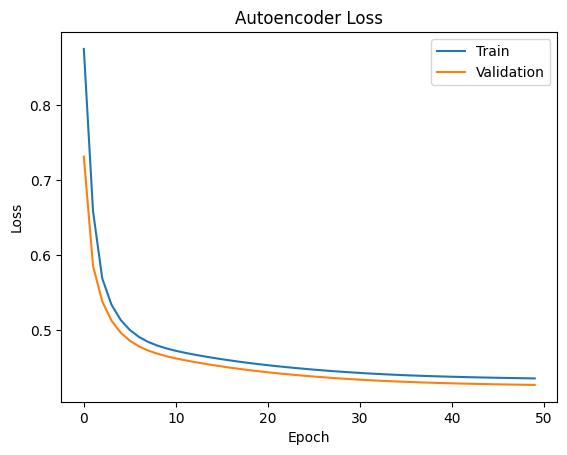

In [ ]:
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('autoencoder_loss.png')
plt.show()

In [ ]:
# Encode and decode some data
encoded_data = autoencoder.predict(test_data)
reconstructed_data = autoencoder.predict(encoded_data)

410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step


In [ ]:
import tensorflow as tf
print("GPU devices:")
for device in tf.config.list_physical_devices('GPU'):
    print(device)


GPU devices:


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [21]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())


True


In [22]:
print(tf.config.list_physical_devices('GPU'))


[]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.17.0
